In [1]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import pickle
import GPy
import GPyOpt
from sklearn.svm import SVC
rs=1234

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#load in our functions for BO
#

In [2]:
#data preparation
np.random.seed(rs)
random.seed(rs)
text=[]
clas = []
classname = ["pos", "neg"]
#load training examples
for item in classname:
    for file in os.listdir("../../Data/aclImdb/test/" +item ):
            filename = "../../Data/aclImdb/test/" +item + "//"+file
            fl = open(filename, "r", encoding="utf8").read()
            fl = re.sub("\n", " ", fl)
            text.append(fl)
            clas.append(item)
#load testing examples
for item in classname:
    for file in os.listdir("../../Data/aclImdb/train/" +item ):
            filename = "../../Data/aclImdb/train/" +item + "//"+file
            fl = open(filename, "r", encoding="utf8").read()
            fl = re.sub("\n", " ", fl)
            text.append(fl)
            clas.append(item)
#store in dataframe
dataframe = pd.DataFrame(clas, columns=['class'])
dataframe["text"] = text
dataframe = shuffle(dataframe)
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
print("We have "+str(len(text))+" classified examples")

#choose 5000 to be fixed training set
#leave remaing 45000 to be test set/represent the population
Y = dataframe["class"].tolist()
X = dataframe["text"].tolist()
X_train_fixed=X[:1000]
Y_train_fixed=Y[:1000]
X_pop=X[1000:]
Y_pop=Y[1000:]
#prepare for training
count_vect = CountVectorizer(min_df = 10, ngram_range = (1, 3),stop_words="english",analyzer='word',max_features=500)
X_train_counts = count_vect.fit_transform(X_train_fixed)
tfidf_transformer = TfidfTransformer()
X_train_fixed_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_pop_counts=count_vect.transform(X_pop)
X_pop_tfidf=tfidf_transformer.transform(X_pop_counts)

We have 50000 classified examples


# BO RF experiment

In [ ]:
#one seed

In [7]:
fit_RF_varied(np.array([[0.2,1000,4,0.2,0.2]]))

array([[-0.535]])

In [8]:
seed=1234

import GPyOpt
#optimize

#set up possible parameters
domain=[{'name': 'max_features',      'type': 'continuous', 'domain': (0.00001,1)},

        {'name': 'max_depth', 'type':'discrete', 'domain':tuple(range(2,6))},
       		{'name': 'min_samples_split',  'type': 'continuous', 'domain': (0.00000001,0.5)},
       {'name': 'min_samples_leaf',  'type': 'continuous', 'domain': (0.00000001,0.5)}
	] 

np.random.seed(seed)
random.seed(seed)
def fit_RF_varied(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        clf=RandomForestClassifier(random_state=1234,n_estimators=1000,max_features=x[i,0],max_depth=int(x[i,1]),min_samples_split=x[i,2],min_samples_leaf=x[i,3],n_jobs=2)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=5, shuffle=True,random_state=1234)))
    return fs

#initialize grid! of 32 elements
X_start=np.array([[0.3,2,0.15,0.15],
         [0.3,2,0.15,0.3],
         [0.3,2,0.3,0.15],
         [0.3,2,0.3,0.3],
         [0.3,5,0.15,0.15],
         [0.3,5,0.15,0.3],
         [0.3,5,0.3,0.15],
         [0.3,5,0.3,0.3],
         [0.6,2,0.15,0.15],
         [0.6,2,0.15,0.3],
         [0.6,2,0.3,0.15],
         [0.6,2,0.3,0.3],
         [0.6,5,0.15,0.15],
         [0.6,5,0.15,0.3],
         [0.6,5,0.3,0.15],
         [0.6,5,0.3,0.3],
        ])






Y_start=np.array([fit_RF_varied(np.array([x])) for x in X_start]).reshape(-1,1)



from functools import partial 
opt = GPyOpt.methods.BayesianOptimization(f =fit_RF_varied,  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='LCB',      
                                          X=X_start,
                                          Y=Y_start,
                                          noise_var=0.001,
                                          model_update_interval=1,
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )   

The set cost function is ignored! LCB acquisition does not make sense with cost.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


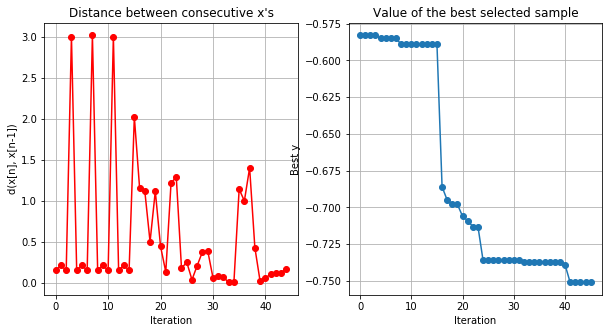

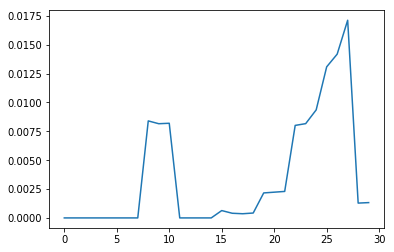

In [9]:

chosen_params=[]
scores=[]
predicted_score_best=[]
noise=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=-1)
    predicted_score_best.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    RF_opt = RandomForestClassifier(random_state=42,n_jobs=4,max_features=best[0],max_depth=int(best[1]),n_estimators=1000,min_samples_split=best[2],min_samples_leaf=best[3])
    RF_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    chosen_params.append([best[0],best[1],best[2],best[3]])
    score=RF_opt.score(X_pop_tfidf,Y_pop)
    scores.append(score)
    noise.append(opt.model.get_model_parameters()[0][2])
opt.plot_convergence()
opt.plot_acquisition()
plt.plot(noise)


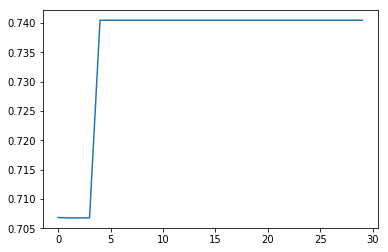

In [16]:
plt.plot(scores)

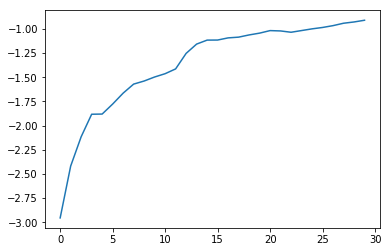

In [6]:
plt.plot(predicted_score_best)

In [7]:
opt.model.__dict__


{'ARD': False,
 'exact_feval': False,
 'input_dim': 4,
 'kernel': None,
 'max_iters': 1000,
 'model': <GPy.models.gp_regression.GPRegression at 0x7f8e01583588>,
 'noise_var': 0.001,
 'num_inducing': 10,
 'optimize_restarts': 5,
 'optimizer': 'lbfgs',
 'sparse': False,
 'verbose': False}

In [ ]:
#another seed


In [158]:
seed=1234

import GPyOpt
#optimize

#set up possible parameters
domain=[{'name': 'max_features',      'type': 'continuous', 'domain': (0.00001,1)},
        {'name': 'n_estimators',  'type': 'discrete', 'domain': tuple(range(50,150))},
        {'name': 'max_depth', 'type':'discrete', 'domain':tuple(range(2,6))},
       		{'name': 'min_samples_split',  'type': 'continuous', 'domain': (0.00000001,0.5)},
       {'name': 'min_samples_leaf',  'type': 'continuous', 'domain': (0.00000001,0.5)}
	] 

np.random.seed(seed)
random.seed(seed)
def fit_RF_varied(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        clf=RandomForestClassifier(random_state=1234,max_features=x[i,0],n_estimators=int(x[i,1]),max_depth=int(x[i,2]),min_samples_split=x[i,3],min_samples_leaf=x[i,4],n_jobs=1)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=5, shuffle=True)))
    return fs

#initialize grid! of 32 elements
X_start=np.array([[0.3,80,2,0.15,0.15],
         [0.3,80,2,0.15,0.3],
         [0.3,80,2,0.3,0.15],
         [0.3,80,2,0.3,0.3],
         [0.3,80,5,0.15,0.15],
         [0.3,80,5,0.15,0.3],
         [0.3,80,5,0.3,0.15],
         [0.3,80,5,0.3,0.3],
         [0.3,120,2,0.15,0.15],
         [0.3,120,2,0.15,0.3],
         [0.3,120,2,0.3,0.15],
         [0.3,120,2,0.3,0.3],
         [0.3,120,5,0.15,0.15],
         [0.3,120,5,0.15,0.3],
         [0.3,120,5,0.3,0.15],
         [0.3,120,5,0.3,0.3],
         [0.6,80,2,0.15,0.15],
         [0.6,80,2,0.15,0.3],
         [0.6,80,2,0.3,0.15],
         [0.6,80,2,0.3,0.3],
         [0.6,80,5,0.15,0.15],
         [0.6,80,5,0.15,0.3],
         [0.6,80,5,0.3,0.15],
         [0.6,80,5,0.3,0.3],
         [0.6,120,2,0.15,0.15],
         [0.6,120,2,0.15,0.3],
         [0.6,120,2,0.3,0.15],
         [0.6,120,2,0.3,0.3],
         [0.6,120,5,0.15,0.15],
         [0.6,120,5,0.15,0.3],
         [0.6,120,5,0.3,0.15],
         [0.6,120,5,0.3,0.3]
        ])

Y_start=np.array([fit_RF_varied(np.array([x])) for x in X_start]).reshape(-1,1)



from functools import partial 
opt = GPyOpt.methods.BayesianOptimization(f =fit_RF_varied,  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='EI',      
                                          X=X_start,
                                          Y=Y_start,
                                          noise_var=0.001,
                                          model_update_interval=1,
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


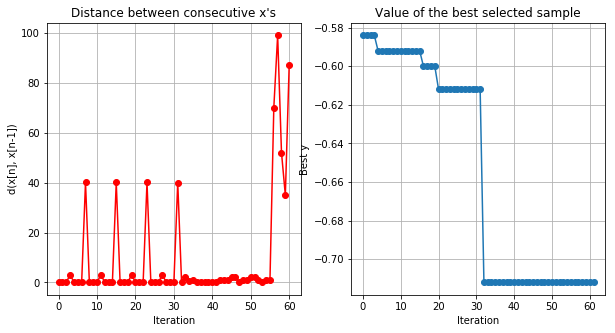

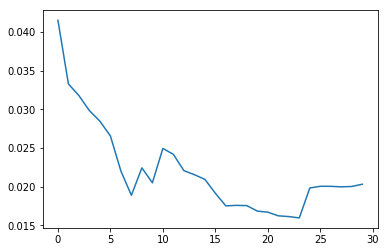

In [159]:
chosen_params=[]
scores=[]
predicted_score_best=[]
noise=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    RF_opt = RandomForestClassifier(random_state=42,n_jobs=4,max_features=best[0],max_depth=int(best[2]),n_estimators=int(best[1]),min_samples_split=best[3],min_samples_leaf=best[4])
    RF_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    chosen_params.append([best[0],best[1],best[2],best[3],best[4]])
    score=RF_opt.score(X_pop_tfidf,Y_pop)
    scores.append(score)
    noise.append(opt.model.get_model_parameters()[0][2])
opt.plot_convergence()
opt.plot_acquisition()
plt.plot(noise)


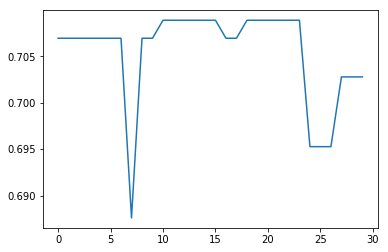

In [160]:
plt.plot(scores)

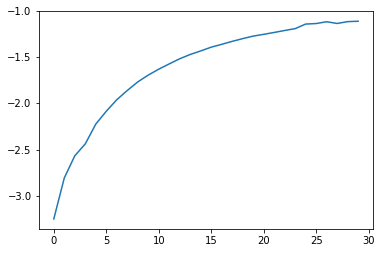

In [161]:
plt.plot(predicted_score_best)

In [ ]:
#try not tuning hyperparams

In [162]:
seed=1234

import GPyOpt
#optimize

#set up possible parameters
domain=[{'name': 'max_features',      'type': 'continuous', 'domain': (0.00001,1)},
        {'name': 'n_estimators',  'type': 'discrete', 'domain': tuple(range(50,150))},
        {'name': 'max_depth', 'type':'discrete', 'domain':tuple(range(2,6))},
       		{'name': 'min_samples_split',  'type': 'continuous', 'domain': (0.00000001,0.5)},
       {'name': 'min_samples_leaf',  'type': 'continuous', 'domain': (0.00000001,0.5)}
	] 

np.random.seed(seed)
random.seed(seed)
def fit_RF_varied(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        clf=RandomForestClassifier(random_state=1234,max_features=x[i,0],n_estimators=int(x[i,1]),max_depth=int(x[i,2]),min_samples_split=x[i,3],min_samples_leaf=x[i,4],n_jobs=1)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=5, shuffle=True)))
    return fs

#initialize grid! of 32 elements
X_start=np.array([[0.3,80,2,0.15,0.15],
         [0.3,80,2,0.15,0.3],
         [0.3,80,2,0.3,0.15],
         [0.3,80,2,0.3,0.3],
         [0.3,80,5,0.15,0.15],
         [0.3,80,5,0.15,0.3],
         [0.3,80,5,0.3,0.15],
         [0.3,80,5,0.3,0.3],
         [0.3,120,2,0.15,0.15],
         [0.3,120,2,0.15,0.3],
         [0.3,120,2,0.3,0.15],
         [0.3,120,2,0.3,0.3],
         [0.3,120,5,0.15,0.15],
         [0.3,120,5,0.15,0.3],
         [0.3,120,5,0.3,0.15],
         [0.3,120,5,0.3,0.3],
         [0.6,80,2,0.15,0.15],
         [0.6,80,2,0.15,0.3],
         [0.6,80,2,0.3,0.15],
         [0.6,80,2,0.3,0.3],
         [0.6,80,5,0.15,0.15],
         [0.6,80,5,0.15,0.3],
         [0.6,80,5,0.3,0.15],
         [0.6,80,5,0.3,0.3],
         [0.6,120,2,0.15,0.15],
         [0.6,120,2,0.15,0.3],
         [0.6,120,2,0.3,0.15],
         [0.6,120,2,0.3,0.3],
         [0.6,120,5,0.15,0.15],
         [0.6,120,5,0.15,0.3],
         [0.6,120,5,0.3,0.15],
         [0.6,120,5,0.3,0.3]
        ])

Y_start=np.array([fit_RF_varied(np.array([x])) for x in X_start]).reshape(-1,1)



from functools import partial 
opt = GPyOpt.methods.BayesianOptimization(f =fit_RF_varied,  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='EI',      
                                          X=X_start,
                                          Y=Y_start,
                                          noise_var=0.001,
                                          model_update_interval=1000,
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


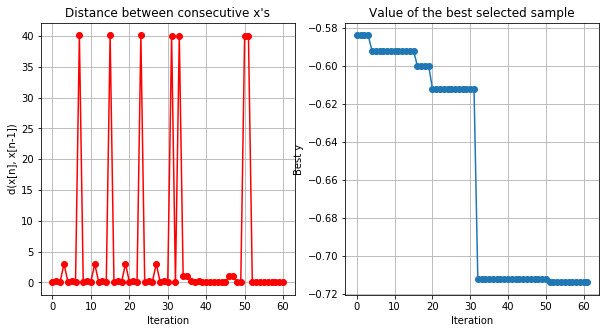

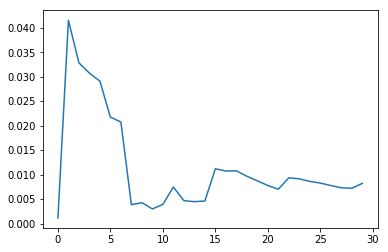

In [163]:
chosen_params=[]
scores=[]
predicted_score_best=[]
noise=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    RF_opt = RandomForestClassifier(random_state=42,n_jobs=4,max_features=best[0],max_depth=int(best[2]),n_estimators=int(best[1]),min_samples_split=best[3],min_samples_leaf=best[4])
    RF_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    chosen_params.append([best[0],best[1],best[2],best[3],best[4]])
    score=RF_opt.score(X_pop_tfidf,Y_pop)
    scores.append(score)
    noise.append(opt.model.get_model_parameters()[0][2])
opt.plot_convergence()
opt.plot_acquisition()
plt.plot(noise)


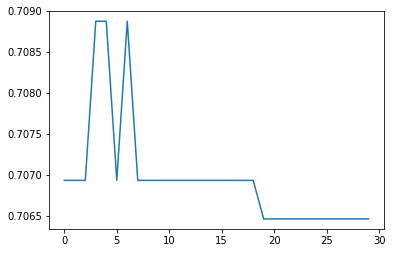

In [164]:
plt.plot(scores)

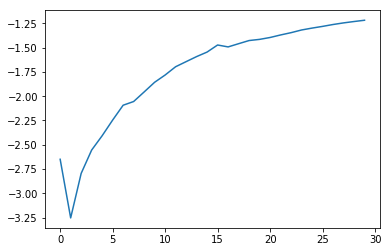

In [165]:
plt.plot(predicted_score_best)

In [ ]:
#try aug

In [166]:
seed=1234

import GPyOpt
import GPyOpt_edit.GPyOpt_edit as GPyOpt2
#optimize

#set up possible parameters
domain=[{'name': 'max_features',      'type': 'continuous', 'domain': (0.00001,1)},
        {'name': 'n_estimators',  'type': 'discrete', 'domain': tuple(range(50,150))},
        {'name': 'max_depth', 'type':'discrete', 'domain':tuple(range(2,6))},
       		{'name': 'min_samples_split',  'type': 'continuous', 'domain': (0.00000001,0.5)},
       {'name': 'min_samples_leaf',  'type': 'continuous', 'domain': (0.00000001,0.5)}
	] 

np.random.seed(seed)
random.seed(seed)
def fit_RF_varied(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        clf=RandomForestClassifier(random_state=1234,max_features=x[i,0],n_estimators=int(x[i,1]),max_depth=int(x[i,2]),min_samples_split=x[i,3],min_samples_leaf=x[i,4],n_jobs=1)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=5, shuffle=True)))
    return fs

#initialize grid! of 32 elements
X_start=np.array([[0.3,80,2,0.15,0.15],
         [0.3,80,2,0.15,0.3],
         [0.3,80,2,0.3,0.15],
         [0.3,80,2,0.3,0.3],
         [0.3,80,5,0.15,0.15],
         [0.3,80,5,0.15,0.3],
         [0.3,80,5,0.3,0.15],
         [0.3,80,5,0.3,0.3],
         [0.3,120,2,0.15,0.15],
         [0.3,120,2,0.15,0.3],
         [0.3,120,2,0.3,0.15],
         [0.3,120,2,0.3,0.3],
         [0.3,120,5,0.15,0.15],
         [0.3,120,5,0.15,0.3],
         [0.3,120,5,0.3,0.15],
         [0.3,120,5,0.3,0.3],
         [0.6,80,2,0.15,0.15],
         [0.6,80,2,0.15,0.3],
         [0.6,80,2,0.3,0.15],
         [0.6,80,2,0.3,0.3],
         [0.6,80,5,0.15,0.15],
         [0.6,80,5,0.15,0.3],
         [0.6,80,5,0.3,0.15],
         [0.6,80,5,0.3,0.3],
         [0.6,120,2,0.15,0.15],
         [0.6,120,2,0.15,0.3],
         [0.6,120,2,0.3,0.15],
         [0.6,120,2,0.3,0.3],
         [0.6,120,5,0.15,0.15],
         [0.6,120,5,0.15,0.3],
         [0.6,120,5,0.3,0.15],
         [0.6,120,5,0.3,0.3]
        ])

Y_start=np.array([fit_RF_varied(np.array([x])) for x in X_start]).reshape(-1,1)



from functools import partial 
opt = GPyOpt2.methods.BayesianOptimization(f =fit_RF_varied,  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='AUG_EI',      
                                          X=X_start,
                                          Y=Y_start,
                                          noise_var=0.001,
                                          model_update_interval=1000,
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )  

0
Models printout after each iteration is only available for GP and GP_MCMC models
1
Models printout after each iteration is only available for GP and GP_MCMC models
2
Models printout after each iteration is only available for GP and GP_MCMC models
3
Models printout after each iteration is only available for GP and GP_MCMC models
4
Models printout after each iteration is only available for GP and GP_MCMC models
5
Models printout after each iteration is only available for GP and GP_MCMC models
6
Models printout after each iteration is only available for GP and GP_MCMC models
7
Models printout after each iteration is only available for GP and GP_MCMC models
8
Models printout after each iteration is only available for GP and GP_MCMC models
9
Models printout after each iteration is only available for GP and GP_MCMC models
10
Models printout after each iteration is only available for GP and GP_MCMC models
11
Models printout after each iteration is only available for GP and GP_MCMC models
12

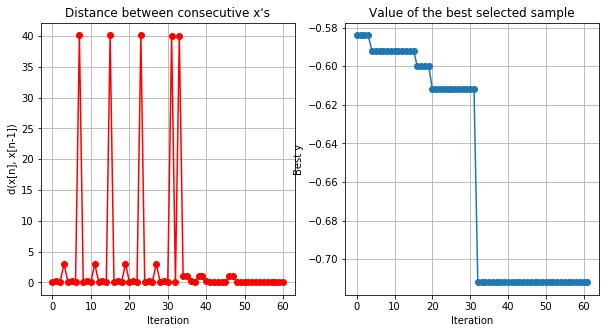

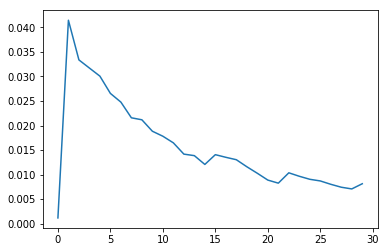

In [167]:
chosen_params=[]
scores=[]
predicted_score_best=[]
noise=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    RF_opt = RandomForestClassifier(random_state=42,n_jobs=4,max_features=best[0],max_depth=int(best[2]),n_estimators=int(best[1]),min_samples_split=best[3],min_samples_leaf=best[4])
    RF_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    chosen_params.append([best[0],best[1],best[2],best[3],best[4]])
    score=RF_opt.score(X_pop_tfidf,Y_pop)
    scores.append(score)
    noise.append(opt.model.get_model_parameters()[0][2])
opt.plot_convergence()
opt.plot_acquisition()
plt.plot(noise)

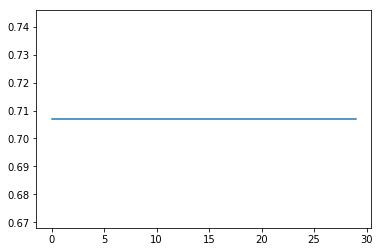

In [168]:
plt.plot(scores)

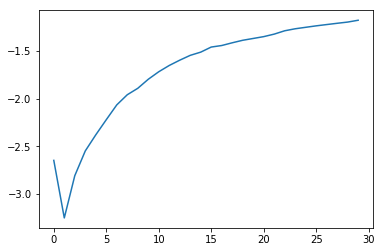

In [169]:
plt.plot(predicted_score_best)

# SVM Fixed


In [ ]:
#set up function to optimize
def fit_svm_fixed(x,cv=None,seed=1234):
    x=np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0], 1))
    clf=RandomForestClassifier(random_state=1234,n_jobs=1)
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], [params[0],int(params[1]),int(params[2])]))
        clf.set_params(**dict_params)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=cv, shuffle=True, random_state=seed)))
    return fs

#set up possible parameters
domain=[{'name': 'C',      'type': 'continuous', 'domain': (-5.,10.)},
        {'name': 'gamma',  'type': 'continuous', 'domain': (-10.,5.)}
        ] 
    

In [ ]:
#optimize
from functools import partial 
opt = GPyOpt.methods.BayesianOptimization(f = partial(fit_svm_varied,cv=5),  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='EI',      
                                          initial_design_numdata=10,
                                          initial_design_type="grid",
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )   


In [ ]:
chosen_params_EI=[]
scores_EI=[]
predicted_score_best_EI=[]
for i in range(0,20):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best_EI.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    SVC_opt = SVC(C =np.exp(best[0]),gamma=np.exp(best[1]))
    SVC_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    score=SVC_opt.score(X_pop_tfidf,Y_pop)
    chosen_params_EI.append([best[0],best[1]])
    scores_EI.append(score)


opt.plot_convergence()
opt.plot_acquisition()

# SVM varied

In [15]:
#set up function to optimize
np.random.seed(1234)
random.seed(1234)

def fit_svm_varied(x,cv=None):
    x=np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0], 1))
    clf=SVC()
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
        clf.set_params(**dict_params)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=cv, shuffle=True)))
    return fs
    
#set up possible parameters
domain=[{'name': 'C',      'type': 'continuous', 'domain': (-5.,10.)},
        {'name': 'gamma',  'type': 'continuous', 'domain': (-10.,5.)}
        ] 
    

In [16]:
#optimize
from functools import partial 
opt = GPyOpt.methods.BayesianOptimization(f = partial(fit_svm_varied,cv=5),  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='EI',      
                                          initial_design_numdata=16,
                                          initial_design_type="grid",
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )   


Note: in grid designs the total number of generated points is the smallest closest integer of n^d to the selected amount of points


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


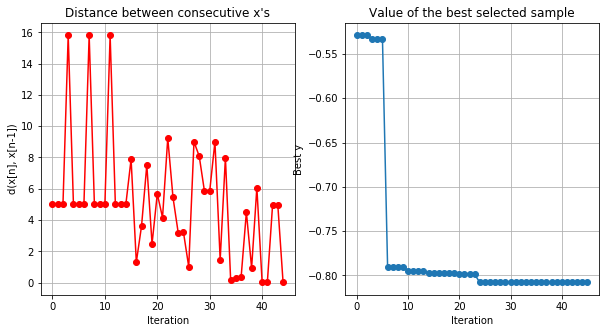

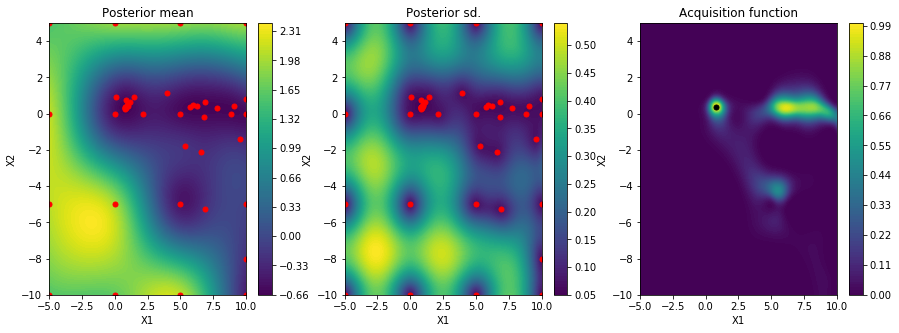

[]

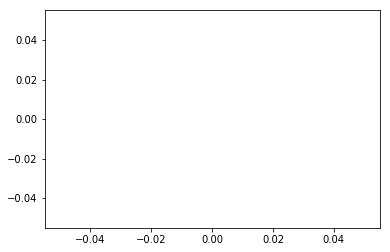

In [17]:
chosen_params_EI=[]
scores_EI=[]
predicted_score_best_EI=[]
noise_EI=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best_EI.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    SVC_opt = SVC(C =np.exp(best[0]),gamma=np.exp(best[1]))
    SVC_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    score=SVC_opt.score(X_pop_tfidf,Y_pop)
    chosen_params_EI.append([best[0],best[1]])
    scores_EI.append(score)
    noise_EI.append(opt.model.get_model_parameters()[0][2])


opt.plot_convergence()
opt.plot_acquisition()
plt.plot()

# new acquisition function

In [21]:
#import editied package
import GPyOpt_edit.GPyOpt_edit as GPyOpt2

np.random.seed(1234)
random.seed(1234)


#set up function to optimize
def fit_svm_varied(x,cv=None):
    x=np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0], 1))
    clf=SVC()
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
        clf.set_params(**dict_params)
        fs[i]=-np.mean(cross_val_score(clf, X_train_fixed_tfidf, Y_train_fixed, cv=KFold(n_splits=cv, shuffle=True)))
    return fs
    
#set up possible parameters
domain=[{'name': 'C',      'type': 'continuous', 'domain': (-5.,10.)},
        {'name': 'gamma',  'type': 'continuous', 'domain': (-10.,5.)}
        ]

In [22]:
#optimize
from functools import partial 

opt = GPyOpt2.methods.BayesianOptimization(f = partial(fit_svm_varied,cv=5),  # function to optimize    
                                            model = "GP",
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='AUG_EI',      
                                          initial_design_numdata=10,
                                          initial_design_type="grid",
                                        noise_var=0.001,
                                          kernel=GPy.kern.Matern52(len(domain))
                                         )   


Note: in grid designs the total number of generated points is the smallest closest integer of n^d to the selected amount of points


0
Models printout after each iteration is only available for GP and GP_MCMC models
1
Models printout after each iteration is only available for GP and GP_MCMC models
2
Models printout after each iteration is only available for GP and GP_MCMC models
3
Models printout after each iteration is only available for GP and GP_MCMC models
4
Models printout after each iteration is only available for GP and GP_MCMC models
5
Models printout after each iteration is only available for GP and GP_MCMC models
6
Models printout after each iteration is only available for GP and GP_MCMC models
7
Models printout after each iteration is only available for GP and GP_MCMC models
8
Models printout after each iteration is only available for GP and GP_MCMC models
9
Models printout after each iteration is only available for GP and GP_MCMC models
10
Models printout after each iteration is only available for GP and GP_MCMC models
11
Models printout after each iteration is only available for GP and GP_MCMC models
12

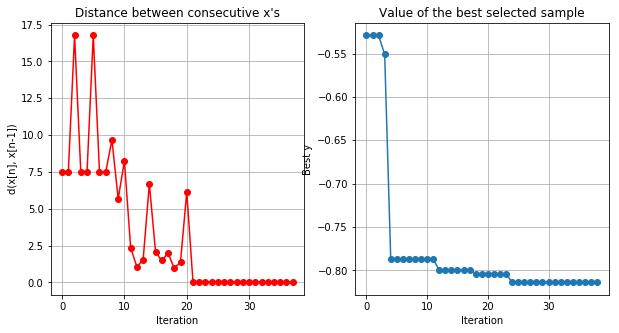

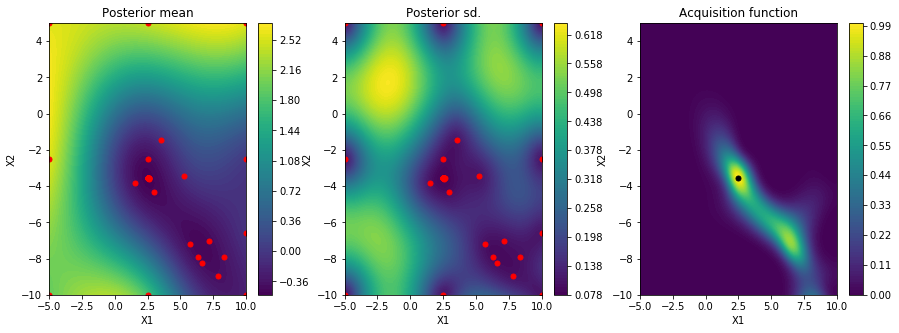

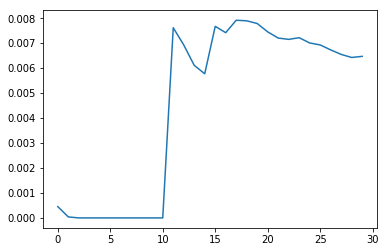

In [23]:
chosen_params_AUG_EI=[]
scores_AUG_EI=[]
predicted_score_best_AUG_EI=[]
noise_AUG_EI=[]
for i in range(0,30):
    print(i)
    opt.run_optimization(max_iter=1,eps=0)
    predicted_score_best_AUG_EI.append(np.min(opt.model.predict(opt.X)[0]))
    best=opt.X[np.argmin(opt.model.predict(opt.X)[0])]
    SVC_opt = SVC(C =np.exp(best[0]),gamma=np.exp(best[1]))
    SVC_opt.fit(X_train_fixed_tfidf, Y_train_fixed)
    score=SVC_opt.score(X_pop_tfidf,Y_pop)
    chosen_params_AUG_EI.append([best[0],best[1]])
    scores_AUG_EI.append(score)
    noise_AUG_EI.append(opt.model.get_model_parameters()[0][2])


opt.plot_convergence()
opt.plot_acquisition()
plt.plot(noise_AUG_EI)

In [24]:
X_start=np.array([[0.3,80,2],
                  [0.3,80,5],
                  [0.3,120,2],
                  [0.3,120,5],
                  [0.6,80,2],
                  [0.6,80,5],
                  [0.6,120,2],
                  [0.6,120,5]
        ])